In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import datetime
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [4]:
url = 'https://raw.githubusercontent.com/Thomas101Shen/Dynamic_hedging/refs/heads/main/Option_SPX.csv'
data = pd.read_csv(url)

In [5]:
print(data.shape)
data.dropna(inplace=True)
print(data.shape)
print(data.head())

feature_cols = ['Moneyness', 'TTM', 'D_BS']

X_train = data[feature_cols].iloc[0:30]
y_train = data['Target'].iloc[0:30]

X_test = data[feature_cols].iloc[30:35]
y_test = data['Target'].iloc[30:35]

print(f'\n\nFeatures:\n {X_train.describe()} \n test features: \n { X_test.describe()} \n\n Training target var data:\n {y_train.describe()}\n test target var data: {y_test.describe()}')

(1008, 14)
(1008, 14)
         Date  ID  Days until next hedge        S  Dividend        C_BS  \
0  2024-10-09   1                      1  5792.04    1.3255  347.319191   
1  2024-08-12   3                      1  5344.39    1.4375   65.911689   
2  2024-08-05   5                      1  5186.33    1.4816   29.540325   
3  2024-11-15   1                      3  5870.62    1.3163  351.552064   
4  2024-09-17   6                      1  5634.58    1.3645   46.314393   

       D_BS   C_mkt  D_Blm        R  TTM  Moneyness  D_Optimal    Target  
0  0.630024  357.80  0.642  4.78852  163      92.04   0.385249 -0.244775  
1  0.227086   74.05  0.247  4.96403  221    -555.61   0.228776  0.001690  
2  0.111161   38.45  0.132  4.95853  228    -913.67  -0.159851 -0.271012  
3  0.685499  370.40  0.710  4.77039  126     170.62   0.377866 -0.307633  
4  0.185447   54.15  0.208  4.76338  185    -565.42   0.160314 -0.025133  


Features:
         Moneyness         TTM       D_BS
count   30.000000   30.

In [6]:
def describe_data(df):
    print(df.describe())
    print("\nSkew: ")
    print(df.skew())
    print("\nKurtosis: ")
    print(df.kurtosis())
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f'Histogram and KDE for {column}')
        plt.show()

# describe_data(X)
# describe_data(y)

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [8]:
y_train.head()

0   -0.244775
1    0.001690
2   -0.271012
3   -0.307633
4   -0.025133
Name: Target, dtype: float64

In [9]:
def plot_train_test(train, test):
    columns = train.columns.tolist()
    for column in columns:
        plt.hist(train[column], bins=30, alpha=0.5
                 , label=f'Training data for {column}')
        plt.hist(test[column], bins=30, alpha=0.5, label=f'Test data for {column}')
        plt.legend()
        plt.title(f'Distribution of {column}')
        plt.show()


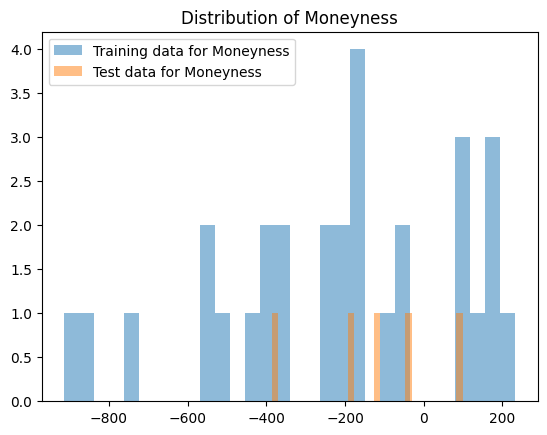

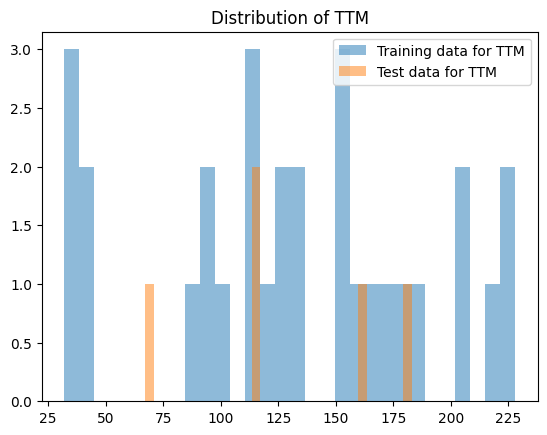

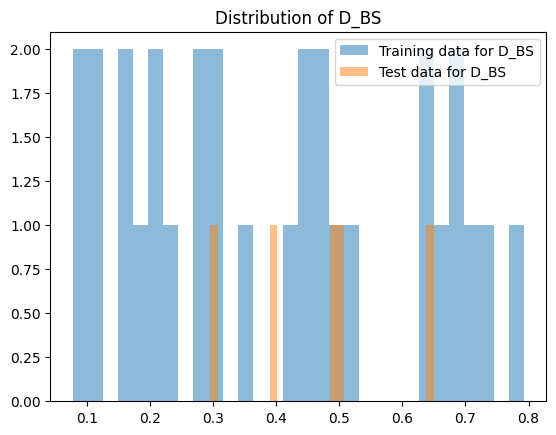

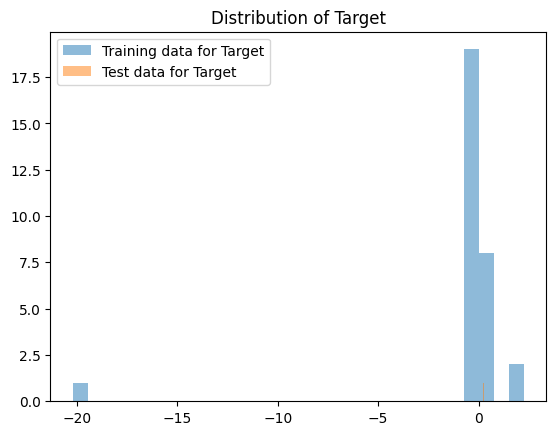

In [10]:
plot_train_test(X_train, X_test)
print("\n\n\n\n\n\n")


y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
plot_train_test(y_train, y_test)

In [13]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

feat_cols = ['Moneyness', 'TTM', 'D_BS']
target_cols = ['Residual']

X_train = pd.DataFrame(X_train, columns=feat_cols)
X_test = pd.DataFrame(X_test, columns=feat_cols)

X_train.to_csv('./X_train.csv')
y_train.to_csv('./y_train.csv')
X_test.to_csv('./X_test.csv')
y_test.to_csv('./y_test.csv')

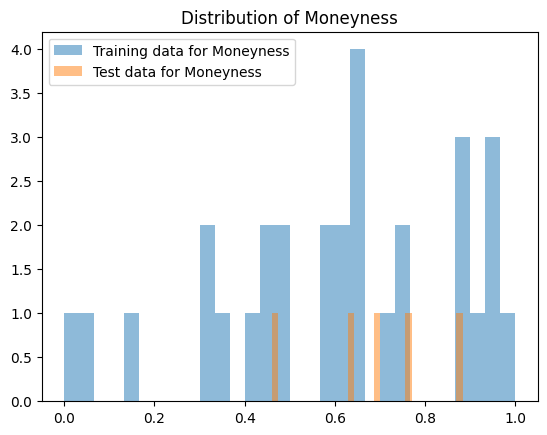

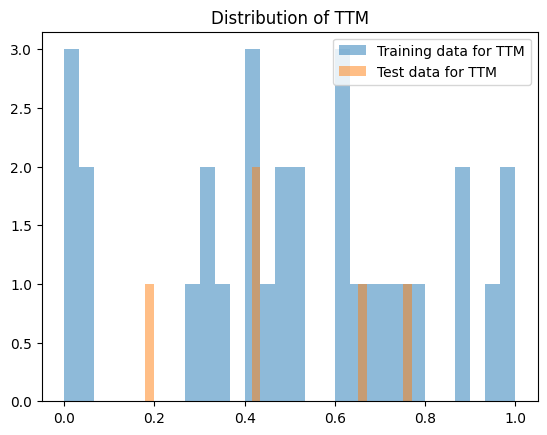

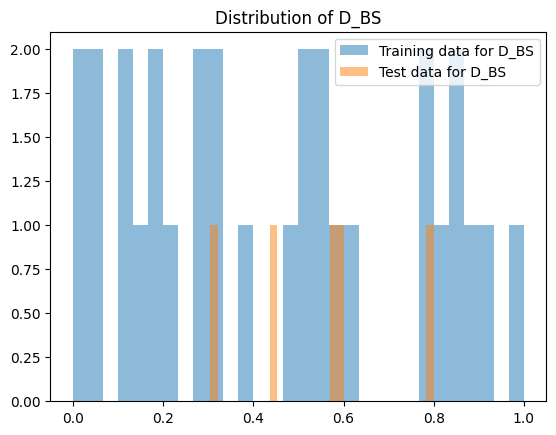

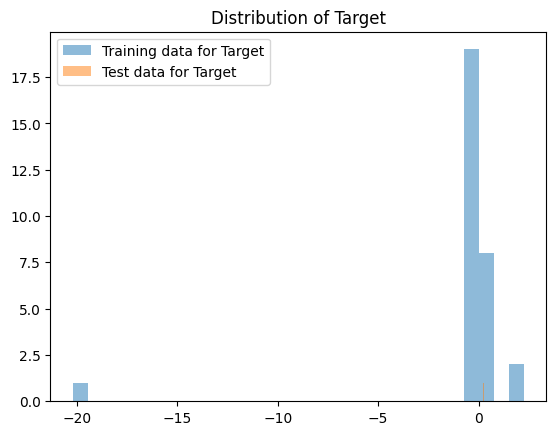

In [15]:
plot_train_test(X_train, X_test)
print("\n\n\n\n\n\n")
plot_train_test(y_train, y_test)

In [16]:
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  # 3 to 6
        self.activation = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)  # 6 to 1

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x


input_size = 3
hidden_size = 6
output_size = 1

In [17]:
model = FNN(input_size, hidden_size, output_size)
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)

y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

In [18]:
def print_tensor_with_precision(tensor, decimals=8):
    """Print a PyTorch tensor or float with specified decimal precision."""
    if isinstance(tensor, float) or tensor.dim() == 0:  # Handle scalar tensors and floats
        print(f"{tensor:.{decimals}f}")
    elif tensor.dim() == 1:  # Handle 1D tensors
        formatted_row = [f"{val:.{decimals}f}, " for val in tensor.tolist()]
        print(" ".join(formatted_row))
    else:  # Handle multi-dimensional tensors
        for row in tensor:  
            formatted_row = [f"{val:.{decimals}f}, " for val in row.tolist()]
            print(" ".join(formatted_row))

In [27]:
def print_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            # print(type(param.data))
            print(f"{name}: {print_tensor_with_precision(param.data)}")
            print("---------------------")
        

In [28]:
def train_model(model, epochs):
    patience = 5
    best_val_loss = float('inf')
    

    for epoch in range(epochs):
        print_parameters(model)
        model.train()

        # Forward pass
        predictions_train = model(X_train)
        loss_train = loss_func(predictions_train, y_train)

        # Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}")
        print("\n\n\n")


train_model(model, 2)

0.44201189,  0.48017010,  -0.13465394, 
0.53072423,  -0.12593791,  0.11686388, 
-0.28085741,  0.33942994,  0.50918502, 
-0.42307943,  0.50260061,  0.10853252, 
0.42647928,  0.07807718,  0.27831981, 
-0.08086531,  0.44614366,  0.08599441, 
hidden.weight: None
---------------------
-0.26882291,  0.14758824,  -0.26573530,  -0.06713052,  -0.23458064,  0.38375959, 
hidden.bias: None
---------------------
-0.32838404,  -0.19408943,  -0.12082455,  -0.25092903,  0.03278520,  -0.41004884, 
output.weight: None
---------------------
0.35934886, 
output.bias: None
---------------------
Epoch [1/2], Training Loss: 13.5705




0.44229701,  0.48064083,  -0.13436420, 
0.53089827,  -0.12566118,  0.11703914, 
-0.28074718,  0.33961061,  0.50929600, 
-0.42285171,  0.50297779,  0.10876206, 
0.42644951,  0.07802873,  0.27828974, 
-0.08056106,  0.44666553,  0.08630805, 
hidden.weight: None
---------------------
-0.26850030,  0.14778423,  -0.26560819,  -0.06686472,  -0.23461464,  0.38410386, 
hidden.bias: Non

In [21]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = loss_func(predictions, y_test)

    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.2443


In [22]:
# Initial model weights

# 0.44201189,  0.48017010,  -0.13465394, 
# 0.53072423,  -0.12593791,  0.11686388, 
# -0.28085741,  0.33942994,  0.50918502, 
# -0.42307943,  0.50260061,  0.10853252, 
# 0.42647928,  0.07807718,  0.27831981, 
# -0.08086531,  0.44614366,  0.08599441, 

In [23]:
        # Batch training code

        # for start in range(0, len(X_shuffled), batch_size):
        #     end = start + batch_size
        #     X_batch = X_shuffled[start:end]
        #     y_batch = y_shuffled[start:end]

        #     # Forward pass
        #     predictions_train = model(X_batch)
        #     loss_train = loss_func(predictions_train, y_batch)

        #     # Backward pass
        #     optimizer.zero_grad()
        #     loss_train.backward()
        #     optimizer.step()

        # model.eval()
        # with torch.no_grad():  # Don't calculate gradient while validating
        #     predictions_val = model(X_val)
        #     loss_val = loss_func(predictions_val, y_val)

        # # Check for improvement
        # if loss_val < best_val_loss:
        #     best_val_loss = loss_val
        #     wait = 0
        # else:
        #     wait += 1
        #     if wait >= patience:
        #         print("Early stoppage")
        #         print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")
        #         break

        # if (epoch + 1) % 5 == 0:

In [24]:

        # indices = torch.randperm(len(X_train))
        # X_shuffled = X_train[indices]
        # y_shuffled = y_train[indices]

        # print(f"Manually Shuffled Features Tensor: {X_shuffled}")
        # print(f"Manually Shuffled Target Tensor: {y_shuffled}")